In [1]:
import yfinance as yf
import pandas as pd
import os as os

In [31]:
file_path = "sp500.csv"
if os.path.exists(file_path):
    sp500 = pd.read_csv(file_path, index_col=0, parse_dates=True)
    sp500.index = pd.to_datetime(sp500.index, utc=True)

    last_date = sp500.index.max()
    today = pd.Timestamp.today().normalize().tz_localize("UTC") 

    if last_date < today: 
        new_data = yf.Ticker("^GSPC").history(start=last_date + pd.Timedelta(days=1), period="max")
        if not new_data.empty:
            sp500 = pd.concat([sp500, new_data])
            sp500.to_csv(file_path)
else:
    sp500 = yf.Ticker("^GSPC").history(period="max")
    sp500.to_csv(file_path) 

In [32]:
sp500.index = pd.to_datetime(sp500.index, utc=True)

In [33]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 05:00:00+00:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 05:00:00+00:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 05:00:00+00:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 05:00:00+00:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-25 05:00:00+00:00,5982.729980,5992.649902,5908.490234,5955.250000,5374690000,0.0,0.0
2025-02-26 05:00:00+00:00,5970.870117,6009.819824,5932.689941,5956.060059,4869580000,0.0,0.0
2025-02-27 05:00:00+00:00,5981.879883,5993.689941,5858.779785,5861.569824,5057680000,0.0,0.0


<Axes: xlabel='Date'>

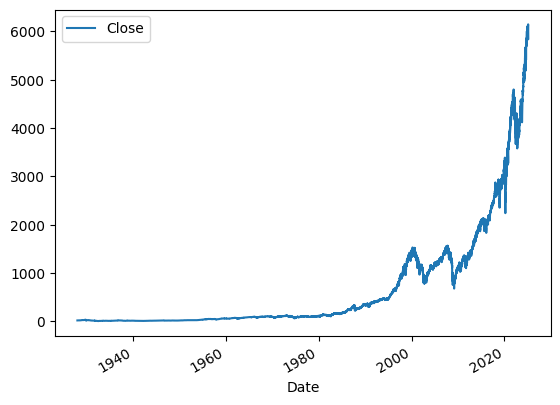

In [34]:
sp500.plot.line(y="Close", use_index=True)

In [35]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [36]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [37]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [38]:
sp500 = sp500.loc["1990-01-01":].copy()

In [39]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [40]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6666666666666666

<Axes: xlabel='Date'>

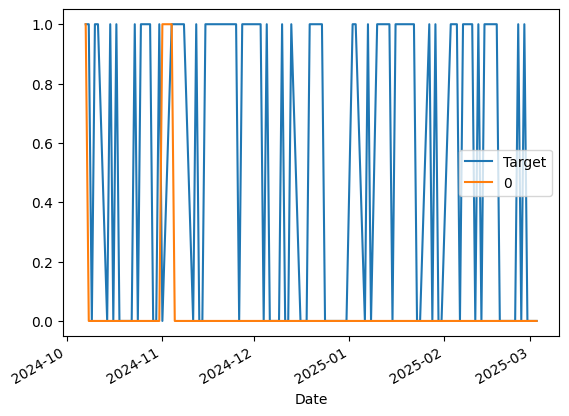

In [41]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [42]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [43]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [44]:
predictions = backtest(sp500, model, predictors)
predictions["Predictions"].value_counts()
precision_score(predictions["Target"], predictions["Predictions"])
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.535945
0    0.464055
Name: count, dtype: float64

In [45]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [46]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [47]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 05:00:00+00:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 05:00:00+00:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 05:00:00+00:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 05:00:00+00:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 05:00:00+00:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-25 05:00:00+00:00,5982.729980,5992.649902,5908.490234,5955.250000,5374690000,5956.060059,1,0.997655,0.0,0.985535,1.0,0.990236,31.0,1.064516,141.0,1.293617,529.0
2025-02-26 05:00:00+00:00,5970.870117,6009.819824,5932.689941,5956.060059,4869580000,5861.569824,0,1.000068,1.0,0.991843,1.0,0.990551,31.0,1.063992,141.0,1.293178,530.0
2025-02-27 05:00:00+00:00,5981.879883,5993.689941,5858.779785,5861.569824,5057680000,5954.500000,1,0.992004,1.0,0.984500,1.0,0.975207,31.0,1.046521,141.0,1.272105,529.0


In [48]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [49]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [50]:
predictions = backtest(sp500, model, new_predictors)

In [51]:
predictions["Predictions"].value_counts()

Predictions
0.0    4492
1.0     865
Name: count, dtype: int64

In [52]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5722543352601156

In [53]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.545455
0    0.454545
Name: count, dtype: float64

In [54]:
predictions

,Target,Predictions
Date,,
2003-11-14 05:00:00+00:00,0,0.0
2003-11-17 05:00:00+00:00,0,1.0
2003-11-18 05:00:00+00:00,1,1.0
2003-11-19 05:00:00+00:00,0,0.0
2003-11-20 05:00:00+00:00,1,1.0
...,...,...
2025-02-25 05:00:00+00:00,1,0.0
2025-02-26 05:00:00+00:00,0,0.0
2025-02-27 05:00:00+00:00,1,0.0


In [55]:
sp500.tail()

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2025-02-25 05:00:00+00:00,5982.729980,5992.649902,5908.490234,5955.250000,5374690000,5956.060059,1,0.997655,0.0,0.985535,1.0,0.990236,31.0,1.064516,141.0,1.293617,529.0
2025-02-26 05:00:00+00:00,5970.870117,6009.819824,5932.689941,5956.060059,4869580000,5861.569824,0,1.000068,1.0,0.991843,1.0,0.990551,31.0,1.063992,141.0,1.293178,530.0
2025-02-27 05:00:00+00:00,5981.879883,5993.689941,5858.779785,5861.569824,5057680000,5954.500000,1,0.992004,1.0,0.984500,1.0,0.975207,31.0,1.046521,141.0,1.272105,529.0
2025-02-28 05:00:00+00:00,5856.740234,5959.399902,5837.660156,5954.500000,6441140000,5849.720215,0,1.007865,1.0,1.002082,2.0,0.990882,31.0,1.062461,141.0,1.291675,530.0
2025-03-03 05:00:00+00:00,5968.330078,5986.089844,5810.910156,5849.720215,3596244000,NaN,0,0.991124,1.0,0.988893,2.0,0.973979,30.0,1.043235,140.0,1.268402,529.0
